

# RNN for Time Series

RNNs are used for sequence modeling. This tutorial will look at a time series data to be modeled and predicted using RNNs. 

In [2]:
#
# Import Libraries
#
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


## Data

We will use retail data for time-series modeling. 

Link to the dataset:
 https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at:
https://www.census.gov/retail/marts/about_the_surveys.html

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted
Frequency:  Monthly

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.

https://fred.stlouisfed.org/series/RSCCASN

### Read data first -  Use index_col = 'DATE' and 'parse_dates = True' as a parameter.

In [3]:
# Your code to read data
df=pd.read_csv("MRTSSM448USN.csv",index_col='DATE',parse_dates=True)
# Print first few rows of data
df.head()

,MRTSSM448USN
DATE,
1992-01-01,6938.0
1992-02-01,7524.0
1992-03-01,8475.0
1992-04-01,9401.0
1992-05-01,9558.0


Does the sales column has any name?

If no, set the name of the colum as 'Sales'.

In [4]:
# Set name of column as 'Sales'. Use - df.columns 
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 386 entries, 1992-01-01 to 2024-02-01
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MRTSSM448USN  386 non-null    float64
dtypes: float64(1)
memory usage: 6.0 KB


Plot your data - Year vs Sales

<Axes: xlabel='DATE'>

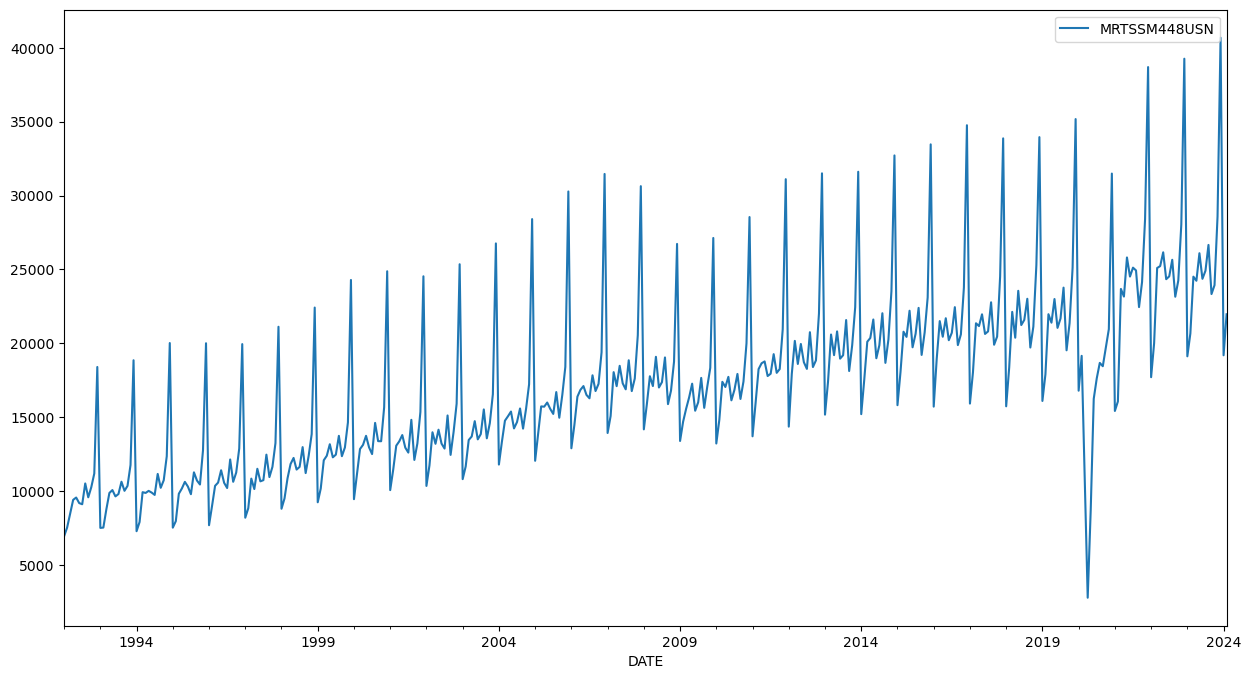

In [5]:
# Your code to plot Year vs Sales. Use either matplot library of pandas dataframe.
df.plot(figsize=(15,8))

### Next we will do Train Test Split. 

We will use last 1.5 year (18 month) samples for testing. Rest is for training.

In [6]:
# Assign variable test size = 18
test_size=18
# Store length of data in variable length.
data_length=len(df)
# store training size in varialable train_size (Remember training size = total size - test_size)
train_size=data_length-test_size
print(test_size)
print(data_length)
print(train_size)

18
386
368


Now, we will find the indexes of the test data. Remember, these are the last 18 indexes in the pandas dataframe.

In [7]:
#Assign the start of test index in data frame to variable test_index.  Remember, it is equal to the length of dataframe - test size
test_index=train_size
test_index

368

Next, we will separate train and test datasets.

In [8]:
# Store all data from 0 to test_index in variable train. Hint - Use df.iloc.
# Store everthing from test_index to the last sample in test variable. Hint - Use df.iloc.
train=df.iloc[:test_index]
test=df.iloc[test_index:]

In [9]:
# Print the size of the train data
print(len(train))
# Print the size of the test data
print(len(test))
# Print the train data
print(train)
# Print the test data
print(test)

368
18
            MRTSSM448USN
DATE                    
1992-01-01        6938.0
1992-02-01        7524.0
1992-03-01        8475.0
1992-04-01        9401.0
1992-05-01        9558.0
...                  ...
2022-04-01       25224.0
2022-05-01       26156.0
2022-06-01       24338.0
2022-07-01       24530.0
2022-08-01       25651.0

[368 rows x 1 columns]
            MRTSSM448USN
DATE                    
2022-09-01       23152.0
2022-10-01       24243.0
2022-11-01       28045.0
2022-12-01       39263.0
2023-01-01       19118.0
2023-02-01       20666.0
2023-03-01       24510.0
2023-04-01       24232.0
2023-05-01       26096.0
2023-06-01       24364.0
2023-07-01       24911.0
2023-08-01       26657.0
2023-09-01       23332.0
2023-10-01       23933.0
2023-11-01       28580.0
2023-12-01       40684.0
2024-01-01       19188.0
2024-02-01       21964.0


### In Neural Networks, we need to Scale Data between 0-1

In [10]:
from sklearn.preprocessing import MinMaxScaler


In [11]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [12]:
#
# Check if the data has been scaled properly
#
print(scaled_train.max())
print(scaled_test.max())
print(scaled_train.min())
print(scaled_test.min())

1.0
1.0553158319645888
0.0
0.4549427911249687


# Time Series Generator

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

#### Arguments
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

# We will use 12 months as input and then predict the next month out


In [13]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [14]:
X, y = generator[0]

print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.11586537 0.13217895 0.15865371 0.1844325  0.18880321 0.17833579
 0.17613652 0.21538933 0.18922079 0.20817906 0.23415272 0.43481529]
Predict this y: 
 [[0.13156649]]


### Create the Model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import GRU

import tensorflow as tf

In [16]:
# We're only using one feature in our time series
n_features = 1

# Define your own models. 

Use 1. SimpleRNN, LSTM, or GRU neural network.

APIs:
https://keras.io/api/layers/recurrent_layers/

In [17]:
# 
# Your code to create your own model
#
model=Sequential()
model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(70,activation='relu'))
model.add(Dense(1))

C:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 70)                  │           7,070 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              71 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,941 (187.27 KB)

 Trainable params: 47,941 (187.27 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(optimizer='adam', loss='mse')

### EarlyStopping and creating a Validation Generator

NOTE: The scaled_test dataset size MUST be greater than your length chosen for your batches. Review video for more info on this.

In [21]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=1)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

# Your code to create an object early-stop.
early_stop=EarlyStopping(monitor='val_loss',patience=5)

Now, fit your model.

In [23]:
# Your code to fit your model.
history=model.fit(generator,epochs=40,
                 validation_data=validation_generator,
                  callbacks=[early_stop])

Epoch 1/40
  7/356 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0814  

C:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


356/356 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0235 - val_loss: 0.0668
Epoch 2/40
356/356 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0159 - val_loss: 0.0452
Epoch 3/40
356/356 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0131 - val_loss: 0.0228
Epoch 4/40
356/356 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0057 - val_loss: 0.0025
Epoch 5/40
356/356 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0055 - val_loss: 0.0047
Epoch 6/40
356/356 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0055 - val_loss: 0.0123
Epoch 7/40
356/356 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0078 - val_loss: 0.0038
Epoch 8/40
356/356 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0036 - val_loss: 0.0119
Epoch 9/40
356/356 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0039 - val_loss: 0.0133


<Axes: >

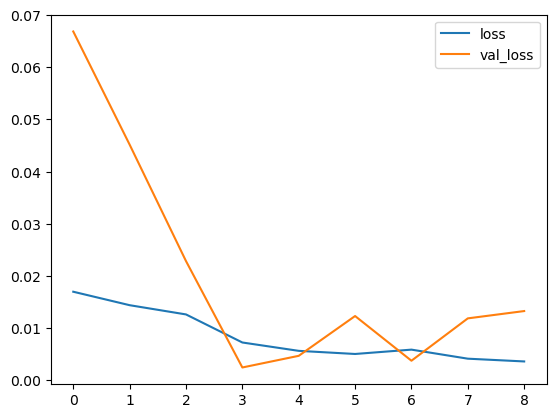

In [24]:
# Get Losses from dataframe (hint - model.history.history)- See previous week tutorial.
losses=pd.DataFrame(model.history.history)
losses
# Plot losses in the dataframe.
losses.plot()

## Evaluate on Test Data

In [25]:
first_eval_batch = scaled_train[-length:]

In [27]:
n_input = 12
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))
model.predict(first_eval_batch)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


array([[0.6662608]], dtype=float32)

In [28]:
# compare with the true result:
scaled_test[0]

array([0.56724479])

#### Try predicting the series!

In [29]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for 
    # grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


## Inverse Transformations and Compare

In [30]:
true_predictions = scaler.inverse_transform(test_predictions)

In [31]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_1680\1339453577.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


# Check and plot predictions

In [32]:
# Print the test variable.
test

,MRTSSM448USN,Predictions
DATE,,
2022-09-01,23152.0,26708.753439
2022-10-01,24243.0,28527.514074
2022-11-01,28045.0,34114.518303
2022-12-01,39263.0,48027.557136
2023-01-01,19118.0,21758.292309
2023-02-01,20666.0,23957.086536
2023-03-01,24510.0,29076.950351
2023-04-01,24232.0,30122.090903
2023-05-01,26096.0,31544.295398


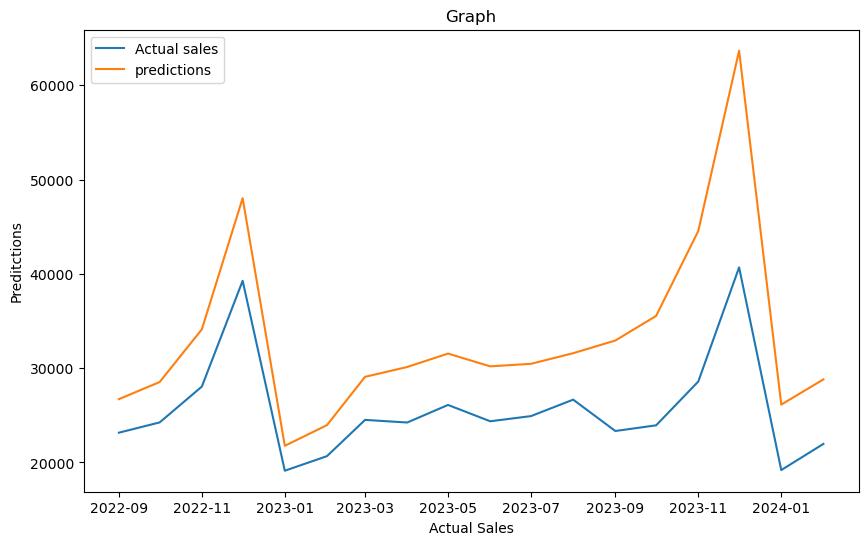

In [40]:
# Your code to plot actual sales and predictions.
plt.figure(figsize=(10, 6))
plt.plot(test['MRTSSM448USN'], label='Actual sales')
plt.xlabel('Actual Sales')
plt.ylabel('Preditctions')
plt.title('Graph')
plt.plot(test['Predictions'], label='predictions')
plt.legend()
plt.show()

# Retrain and Forecasting

In [41]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [42]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, 
                                scaled_full_data, length=length, batch_size=1)

In [43]:
#
# Use any neural network model based on RNN
#
# Create the model
model=Sequential()
model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(70,activation='relu'))
model.add(Dense(1))

C:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# compile the model

In [ ]:
# use early_stop

In [ ]:
# fit the model

In [ ]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for  grabbing just the number instead of [array])
    
    
    # store prediction forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value


In [ ]:
forecast = scaler.inverse_transform(forecast)

### Creating new timestamp index with pandas.

In [ ]:
df

In [ ]:
forecast_index = pd.date_range(start='2024-01-01',periods=periods,freq='MS')

In [ ]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [ ]:
forecast_df

In [ ]:
# Plot sales - Values in dataframe

In [ ]:
# Plot forecast - Values in forecast_df

### Joining pandas plots

https://stackoverflow.com/questions/13872533/plot-different-dataframes-in-the-same-figure

In [ ]:
ax = df.plot()
forecast_df.plot(ax=ax)

In [ ]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2022-01-01','2025-01-01')

# Try the same example with a LSTM and GRU! 
Hint: Use LSTM instead of SimpleRNN!